### Imports

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import keras
import pickle
import time
import tensorflow as tf
from scipy.spatial import distance
from matplotlib import pyplot as plt
import random

Using TensorFlow backend.


### Variables

In [2]:
landmark_code = [
    'nose',
    'left_eye_inner',
    'left_eye',
    'left_eye_outer',
    'right_eye_inner',
    'right_eye',
    'right_eye_outer',
    'left_ear',
    'right_ear',
    'mouth_left',
    'moouth_right',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_pinky',
    'right_pinky',
    'left_index',
    'right_index',
    'left_thumb',
    'right_thumb',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle',
    'left_heel',
    'right_heel',
    'left_foot_index',
    'right_foot_index']

mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}

#Initialize the Mediapipe module with its corresponding parameters
    #model_complexity
    #static_image_mode
    #smooth_landmarks
    #min_detection_confidence
    #min_tracking_confidenced
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(model_complexity=0,min_detection_confidence=0.8,min_tracking_confidence=0.5)

In [3]:
model = keras.models.load_model('../../models/Final_experiments/Experiment_07/model_13,70_mpjpe.h5')
scaler = pickle.load(open('../../models/Final_experiments/Experiment_07/scaler_13,70_mpjpe.pkl','rb'))

#Select the number of keypoints to detect 
number_keypoints_to_detect = 6

#Select the indices of the landmarks of interest to detect from the output of the previous cell
indices_landmark_interest = [11, 12, 13, 14, 15 ,16] #0rder: left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist

### Functions

In [4]:
def mediapipe_inference(frame):
    results = pose.process(frame)
    frame_list1 = []
    start_index = 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            #If landmark visibility is not 0.5 save a NaN and this value will be replaced by the previous recorded value
            #Reference & first value is the callibraition picture 
            
            if landmark.visibility>0.5:
                if start_index in indices_landmark_interest:
                    image_hight, image_width, _ = frame.shape
                    frame = cv2.circle(frame, (int(landmark.x*image_width), int(landmark.y*image_hight)), radius=5, color = (0,255,0), thickness=-1)   
                    frame_list1.append(landmark.x*image_width)
                    frame_list1.append(landmark.y*image_hight) 
                    start_index = start_index+1
                else:
                    start_index = start_index+1
            else: 
                start_index = start_index+1
    return(frame_list1,frame)

def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

def split_2_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 2
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/2)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+2
        output.append(frame_coordinates)
    return(output)

### Load ground truth MOCAP test data

He de carregar les dades del csv MOCAP Adri01 i Xavi01 i quedar-me amb les rows corresponents als fitxers filtrats que son els que detecta bé mediapipe per despres calcular la accuracie de MediaPipe i Martinez per cadascún dels experiments

In [5]:
adri_gt_df_2D = pd.read_csv('../../../MOCAP/data_export_1/Kinect/Adri/Adri01/filtered_csv/2d_TIMECODE_Adri01.csv')
adri_gt_df_3D = pd.read_csv('../../../MOCAP/data_export_1/Kinect/Adri/Adri01/filtered_csv/3d_TIMECODE_Adri01.csv')

final_adri_gt_df_2D = pd.DataFrame(columns=list(adri_gt_df_2D))
final_adri_gt_df_3D = pd.DataFrame(columns=list(adri_gt_df_3D))

In [6]:
for filename in glob('../../../MOCAP/data_final_analysis/Frames_to_analyze/Adri/*.jpg'):
    frame_timecode = (round(float(filename.split('\\')[-1].split('.jpg')[0].split('_')[-1]),3))
    
    final_adri_gt_df_2D = final_adri_gt_df_2D.append(adri_gt_df_2D[adri_gt_df_2D['timecode']==adri_gt_df_2D[adri_gt_df_2D['timecode']<frame_timecode]['timecode'].max()])
    final_adri_gt_df_3D = final_adri_gt_df_3D.append(adri_gt_df_3D[adri_gt_df_2D['timecode']==adri_gt_df_3D[adri_gt_df_3D['timecode']<frame_timecode]['timecode'].max()])

In [7]:
final_adri_gt_df_2D = final_adri_gt_df_2D.drop(columns=['timecode'])
final_adri_gt_df_3D = final_adri_gt_df_3D.drop(columns=['timecode'])

In [8]:
final_adri_gt_df_2D.head(5)

,RightShoulder_2D,RightShoulder_2D.1,RightElbow_2D,RightElbow_2D.1,RightHand_2D,RightHand_2D.1,LeftShoulder_2D,LeftShoulder_2D.1,LeftElbow_2D,LeftElbow_2D.1,LeftHand_2D,LeftHand_2D.1
0,773.356,456.304,657.636,560.617,630.259,677.937,1067.365,425.891,1185.255,539.195,1199.198,669.846
1,775.469,455.505,657.920,563.827,629.928,677.783,1067.784,426.602,1182.842,544.381,1197.515,669.704
2,777.588,454.660,658.795,565.841,630.071,677.754,1068.364,428.452,1180.040,550.553,1196.000,669.003
3,779.998,454.083,659.575,567.215,630.194,677.750,1069.142,430.801,1177.158,558.169,1192.843,668.276
4,782.618,453.640,659.920,568.610,629.676,677.477,1070.220,433.442,1174.691,567.800,1186.762,667.777


In [9]:
final_adri_gt_df_3D.head(5)

,RightShoulder,RightShoulder.1,RightShoulder.2,RightElbow,RightElbow.1,RightElbow.2,RightHand,RightHand.1,RightHand.2,LeftShoulder,LeftShoulder.1,LeftShoulder.2,LeftElbow,LeftElbow.1,LeftElbow.2,LeftHand,LeftHand.1,LeftHand.2
0,-0.232,0.104,1.192,-0.434,-0.030,1.378,-0.394,-0.165,1.147,0.133,0.142,1.191,0.324,0.001,1.383,0.291,-0.158,1.166
1,-0.231,0.106,1.201,-0.434,-0.034,1.380,-0.394,-0.165,1.146,0.135,0.142,1.203,0.323,-0.006,1.391,0.289,-0.158,1.170
2,-0.230,0.107,1.209,-0.434,-0.037,1.383,-0.394,-0.165,1.148,0.137,0.141,1.214,0.321,-0.015,1.401,0.288,-0.158,1.173
3,-0.228,0.109,1.216,-0.434,-0.039,1.385,-0.395,-0.165,1.149,0.139,0.140,1.227,0.319,-0.027,1.409,0.285,-0.157,1.174
4,-0.226,0.110,1.221,-0.433,-0.041,1.386,-0.395,-0.164,1.148,0.142,0.137,1.238,0.316,-0.041,1.414,0.277,-0.156,1.172


In [10]:
final_adri_gt_df_3D = pd.DataFrame(split_3_coordinates(np.array(final_adri_gt_df_3D)))

In [11]:
df_2D = pd.DataFrame(columns=np.arange(0,number_keypoints_to_detect*2))
dfs_3D_list = []

n = 0
mp_time = []
nn_time = []

for filename in glob('../../../MOCAP/data_final_analysis/Frames_to_analyze/Adri/*.jpg'):
    
    frame = cv2.imread(filename)
    start1 = time.time()
    #MediaPipe inference
    detected_keypoints, frame = mediapipe_inference(frame)
    end1=time.time()
    mp_time.append(end1-start1)
    
    df_2D = df_2D.append(pd.DataFrame(detected_keypoints).T)
    
    #Changing prediction order to meet the ground-truth values
    df_2D= df_2D[[2,3,6,7,10,11,0,1,4,5,8,9]]


    #NEURAL NETWORK INFERENCE

    X = np.array([list(df_2D.iloc[n])]).astype(float)
    start2 = time.time()
    X_scaled = scaler.transform(X)
    z_predicted = model.predict(X_scaled)
    end2 = time.time()
    nn_time.append(end2-start2)
    df_pred_3d = pd.DataFrame(split_3_coordinates(z_predicted))
    dfs_3D_list.append(df_pred_3d)
    
    n = n+1
    
final_adri_predicted_df_3D = pd.concat(dfs_3D_list)

### Compute PCK@0.5

In [12]:
final_adri_predicted_df_2D = df_2D.reset_index().drop(columns=['index'])

df_adri_pred_2d = pd.DataFrame(split_2_coordinates(np.array(final_adri_predicted_df_2D).astype(float)))
df_adri_gt_2d = pd.DataFrame(split_2_coordinates(np.array(final_adri_gt_df_2D).astype(float)))

In [13]:
df_adri_pred_2d.head(5)

,0,1,2,3,4,5
0,"[787.1469497680664, 450.69982051849365]","[687.8608131408691, 562.2484731674194]","[630.6749153137207, 717.9231548309326]","[1014.9539566040039, 392.7485918998718]","[1139.0792083740234, 462.3973309993744]","[1182.5852966308594, 530.3490042686462]"
1,"[784.0057182312012, 457.38701820373535]","[686.1524391174316, 571.2008285522461]","[623.7482070922852, 728.903067111969]","[1028.5528564453125, 403.12610149383545]","[1148.4687423706055, 509.29880261421204]","[1211.9335556030273, 674.2989134788513]"
2,"[783.6223983764648, 462.1070408821106]","[684.7611808776855, 577.9782128334045]","[618.7668800354004, 733.6145281791687]","[1037.863998413086, 406.92816495895386]","[1156.333236694336, 532.1137583255768]","[1238.1768035888672, 720.4364061355591]"
3,"[784.0929794311523, 461.1714434623718]","[684.1961288452148, 580.1045823097229]","[616.2969017028809, 736.1250758171082]","[1039.9589538574219, 410.03149151802063]","[1158.442039489746, 538.3197677135468]","[1236.9050216674805, 722.2197318077087]"
4,"[785.8315658569336, 460.8426904678345]","[684.4919013977051, 579.3828964233398]","[617.4900054931641, 734.8188185691833]","[1042.1945571899414, 410.15586018562317]","[1158.3715438842773, 537.5162315368652]","[1233.9684677124023, 724.3686318397522]"


In [14]:
df_adri_gt_2d.head(5)

,0,1,2,3,4,5
0,"[773.356, 456.304]","[657.636, 560.617]","[630.259, 677.937]","[1067.365, 425.891]","[1185.255, 539.195]","[1199.198, 669.846]"
1,"[775.469, 455.505]","[657.92, 563.827]","[629.928, 677.783]","[1067.784, 426.602]","[1182.842, 544.381]","[1197.515, 669.704]"
2,"[777.588, 454.66]","[658.795, 565.841]","[630.071, 677.754]","[1068.364, 428.452]","[1180.04, 550.553]","[1196.0, 669.003]"
3,"[779.998, 454.083]","[659.575, 567.215]","[630.194, 677.75]","[1069.142, 430.801]","[1177.158, 558.169]","[1192.843, 668.276]"
4,"[782.618, 453.64]","[659.92, 568.61]","[629.676, 677.477]","[1070.22, 433.442]","[1174.691, 567.8]","[1186.762, 667.777]"


In [15]:
all_distances = []
for i in range(0,df_adri_pred_2d.shape[1]):
    keypoint_distances = []
    for j in range(0,len(df_adri_gt_2d[i])):
        keypoint_distances.append(distance.euclidean(df_adri_gt_2d[i][j], df_adri_pred_2d[i][j]))
    all_distances.append(keypoint_distances)

df_ED = pd.DataFrame(all_distances).T
df_ED = df_ED.rename(columns=mapping_numbers_variables)

In [16]:
#150 pixels is the head bone link of the woman virtual character. (Head-bone link --> Des de el entrecejo hasta inicio columna)
threshold = 0.5*150 

#Se calcula PCK por cada imágen y luego se hace la media

PCK_per_image = []
for i in range(0,len(df_ED)):
    condition = []
    for di in df_ED.iloc[i]:
        condition.append(di < threshold)
    PCK_per_image.append(sum(condition)/number_keypoints_to_detect)
        
        
PCK = sum(PCK_per_image)/len(PCK_per_image)
print('The PCK@0.5 for the MediaPipe Detections is: '+str(PCK))

The PCK@0.5 for the MediaPipe Detections is: 0.9091627172195884


### MediaPipe output vs GroundTruth (MOCAP)

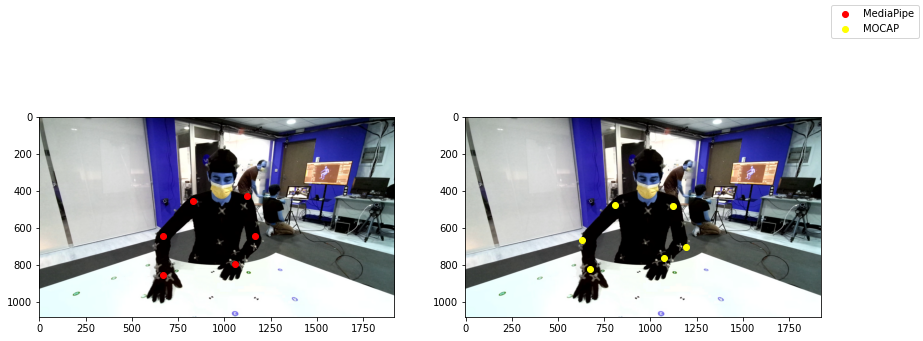

In [17]:
all_adri_images = glob('../../../MOCAP/data_final_analysis/Frames_to_analyze/Adri/*.jpg')

random_adri_image = random.sample(all_adri_images,1)
index = all_adri_images.index(random_adri_image[0])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.imshow(cv2.imread(random_adri_image[0]))
ax1.scatter(np.array(list(df_adri_pred_2d.iloc[index]))[:,0],np.array(list(df_adri_pred_2d.iloc[index]))[:,1],c='red',label='MediaPipe')

ax2.imshow(cv2.imread(random_adri_image[0]))
ax2.scatter(np.array(list(df_adri_gt_2d.iloc[index]))[:,0],np.array(list(df_adri_gt_2d.iloc[index]))[:,1],c='yellow',label='MOCAP')
fig.legend()

### Compute MPJPE

In [18]:
final_adri_gt_df_3D.head(5)

,0,1,2,3,4,5
0,"[-0.232, 0.104, 1.192]","[-0.434, -0.03, 1.378]","[-0.394, -0.165, 1.147]","[0.133, 0.142, 1.191]","[0.324, 0.001, 1.383]","[0.291, -0.158, 1.166]"
1,"[-0.231, 0.106, 1.201]","[-0.434, -0.034, 1.38]","[-0.394, -0.165, 1.146]","[0.135, 0.142, 1.203]","[0.323, -0.006, 1.391]","[0.289, -0.158, 1.17]"
2,"[-0.23, 0.107, 1.209]","[-0.434, -0.037, 1.383]","[-0.394, -0.165, 1.148]","[0.137, 0.141, 1.214]","[0.321, -0.015, 1.401]","[0.288, -0.158, 1.173]"
3,"[-0.228, 0.109, 1.216]","[-0.434, -0.039, 1.385]","[-0.395, -0.165, 1.149]","[0.139, 0.14, 1.227]","[0.319, -0.027, 1.409]","[0.285, -0.157, 1.174]"
4,"[-0.226, 0.11, 1.221]","[-0.433, -0.041, 1.386]","[-0.395, -0.164, 1.148]","[0.142, 0.137, 1.238]","[0.316, -0.041, 1.414]","[0.277, -0.156, 1.172]"


In [19]:
final_adri_predicted_df_3D = final_adri_predicted_df_3D.reset_index().drop(columns=['index'])
final_adri_predicted_df_3D.head(5)

,0,1,2,3,4,5
0,"[-0.157549, 0.13168862, 1.2974248]","[-0.3182609, -0.029162213, 1.3814086]","[-0.3273939, -0.18533924, 1.1822097]","[0.14953859, 0.20686613, 1.3514416]","[0.3371644, 0.072305486, 1.6122935]","[0.34076992, -0.065345585, 1.4467709]"
1,"[-0.15224436, 0.1006112, 1.1623919]","[-0.32869777, -0.045348577, 1.3279449]","[-0.3487674, -0.21591584, 1.1253222]","[0.1597215, 0.16164702, 1.1706407]","[0.35191634, 0.020424634, 1.3655488]","[0.37253663, -0.19121334, 1.1887456]"
2,"[-0.16069922, 0.094138406, 1.1489612]","[-0.34103844, -0.053639084, 1.3173888]","[-0.3634675, -0.21909636, 1.1136277]","[0.15973929, 0.15595515, 1.1504725]","[0.3450966, 0.0007119626, 1.2912525]","[0.37833828, -0.21502754, 1.1137732]"
3,"[-0.16044614, 0.09528085, 1.1521202]","[-0.34091282, -0.05603578, 1.3149045]","[-0.36455393, -0.22046661, 1.1086472]","[0.16130798, 0.15324704, 1.1561298]","[0.34718633, -0.0072468966, 1.2956418]","[0.37639436, -0.21607918, 1.1119981]"
4,"[-0.15828997, 0.095450215, 1.15101]","[-0.34008878, -0.055564776, 1.3149663]","[-0.36227632, -0.22011818, 1.109852]","[0.1635294, 0.15275249, 1.1526959]","[0.34636286, -0.0053084195, 1.2912756]","[0.3730285, -0.21696588, 1.1092902]"


In [20]:
#Compute the euclidean distances of each 3D predicted keypoint vs the ground truth and generate a dataframe with the results.
all_distances = []
for keypoint in list(mapping_numbers_variables.keys()):
    
    keypoint_distances = []
    for i in range(0,len(final_adri_gt_df_3D[keypoint])):    
        keypoint_distances.append(distance.euclidean(final_adri_gt_df_3D[keypoint][i], final_adri_predicted_df_3D[keypoint][i]))
    all_distances.append(keypoint_distances)

df_PJPE = pd.DataFrame(all_distances).T

#Per joint position error dataframe euclidean distance in [mm]
(df_PJPE*1000).head(5)

,0,1,2,3,4,5
0,131.999997,115.792304,78.037067,173.846639,240.485498,299.823593
1,87.875340,118.013074,71.175710,45.213732,46.713780,91.830782
2,92.588758,114.993672,70.993704,69.112026,113.454953,122.151363
3,93.980659,117.765984,75.045685,75.469927,118.468309,125.249815
4,98.462884,117.857584,75.335004,89.378108,131.366150,129.887732


In [21]:
df_PJPE_mm = df_PJPE*1000

In [22]:
means = []
for column in list(df_PJPE.columns):
    means.append(df_PJPE[column].mean())
    
mpjpe = sum(means)/len(df_PJPE.columns)
print('The obtained MPJPE error is: '+'\033[1m'+str(mpjpe*1000)+'mm')

The obtained MPJPE error is: 70.81779639442759mm


In [23]:
df_PJPE.mean()*1000

0    62.920788
1    92.393411
2    65.523442
3    48.089479
4    97.927279
5    58.052380
dtype: float64

In [24]:
df_PJPE.std()*1000

0    17.248679
1    24.874131
2    32.153891
3    21.728512
4    29.739357
5    34.581901
dtype: float64

([<matplotlib.axis.XTick at 0x1fc280135c8>,
 [Text(1, 0, 'right_shoulder'),
  Text(2, 0, 'right_elbow'),
  Text(3, 0, 'right_wrist'),
  Text(4, 0, 'left_shoulder'),
  Text(5, 0, 'left_elbow'),
  Text(6, 0, 'left_wrist')])

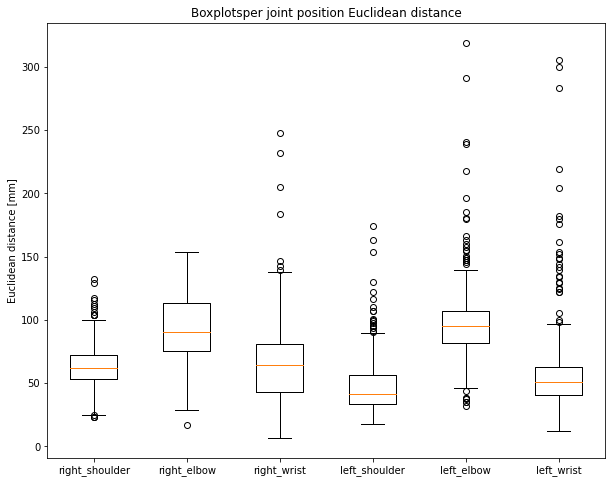

In [25]:
fig = plt.figure(figsize=(10,8))
plt.boxplot(df_PJPE*1000)
plt.title('Boxplotsper joint position Euclidean distance')
plt.ylabel('Euclidean distance [mm]')
#plt.ylim([0,80])
positions = list(mapping_numbers_variables.keys())
positions = [i+1 for i in positions]
labels = list(mapping_numbers_variables.values())
plt.xticks(positions,labels)

### Outliers analysis

In [26]:
q3_list = list(df_PJPE_mm.quantile(0.75))
q1_list = list(df_PJPE_mm.quantile(0.25))
iqr_list = list(np.array(q3_list)-np.array(q1_list))
maximum_values_list = np.array(q3_list) + 1.5*np.array(iqr_list)
max_values_dict = dict(zip(mapping_numbers_variables.values(),maximum_values_list))

In [27]:
q3_list = list(df_PJPE_mm.quantile(0.75))
q1_list = list(df_PJPE_mm.quantile(0.25))
iqr_list = list(np.array(q3_list)-np.array(q1_list))
maximum_values_list = np.array(q3_list) + 1.5*np.array(iqr_list)
max_values_dict = dict(zip(mapping_numbers_variables.values(),maximum_values_list))

#How many outliers there are per each keypoint?
df_outliers = pd.DataFrame(columns = np.arange(0,number_keypoints_to_detect))
df_outliers = df_outliers.rename(columns=mapping_numbers_variables)
for keypoint in max_values_dict.keys():
    outliers = df_PJPE_mm[df_PJPE_mm[keypoint] >  max_values_dict.get(keypoint)]
    df_outliers = df_outliers.append(outliers)
    print('There are '+str(len(outliers))+' outliers for keypoint: '+str(keypoint))

KeyError: 'right_shoulder'

In [ ]:
df_outliers = df_outliers.drop_duplicates()
for i in range(0,len(files)):
    if i in df_outliers.index:
        shutil.copy(files[i],'../../../MOCAP/data_final_analysis/Frames_to_analyze/Adri/outliers/'+files[i].split('\\')[-1])
        

### Plotting 3D

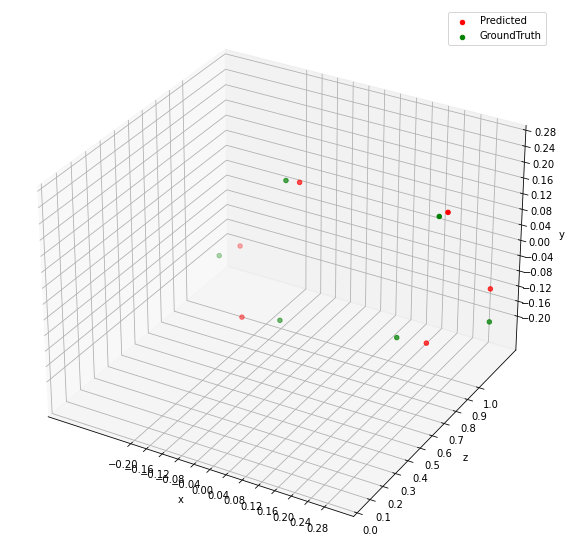

In [37]:
index = random.randint(0,len(glob('../../../MOCAP/data_final_analysis/Frames_to_analyze/Adri/*.jpg')))

x_line = []
y_line = []
z_line = []

for keypoint in list(final_adri_predicted_df_3D.iloc[index]):
    x_line.append(keypoint[0])
    y_line.append(keypoint[1])
    z_line.append(keypoint[2])
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

x_line2 = []
y_line2 = []
z_line2 = []

for keypoint in list(final_adri_gt_df_3D.iloc[index]):
    x_line2.append(keypoint[0])
    y_line2.append(keypoint[1])
    z_line2.append(keypoint[2])
    



ax.scatter(x_line, z_line,y_line,c='red',label='Predicted')
ax.scatter(x_line2, z_line2,y_line2,c='green',label='GroundTruth')

ax.set_xticks(np.arange(-0.2,0.3,0.04))
ax.set_xlabel('x')
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_ylabel('z')
ax.set_zticks(np.arange(-0.2,0.3,0.04))
ax.set_zlabel('y')
#ax.set_title('Predicted 3D coordinates')
ax.legend()